# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки и анализа данных.
- навыки анализа и предварительной обработки данных
- использование моделей Машинного Обучения:
    - CatBoost
    - XGBoost
    - LightGBM

Проект включает в себя:
1. Предварительная обработка данных
2. Исследование моделей машинного обучения:
    - Подбор параметров моделей
    - Выбор лучшей моделей для решения задачи

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip install xgboost

In [3]:
!pip install lightgbm

In [4]:
!pip install catboost

## Импорт библиотек

In [5]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Модели машинного обучения для задач регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
# Для предобработки данных
from sklearn.impute import SimpleImputer
# Метрики регрессии - оценка моделей
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,make_scorer
# Для масшатбирования признаков
# Для масшатбирования признаков, кодирования
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Проверка моделей на вменяемость
from sklearn.dummy import DummyRegressor
# Для разделения данных на обучающий, валидационный, тестовый набор данных. 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Настройка matplotlib

In [6]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [7]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [8]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [9]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

# Численные методы

# Проект "Определение стоимости автомобиля"

## Описание проекта 

Сервис по продаже автомобилей с пробегом разрабатывает приложение, где можно узнать рыночную стоимость своего автомобиля. Необходимо построить модель Машинного Обучения для быстрого определения стоимости автомобиля.

## Детали задачи
Заказчику важны:
- качество предсказания
- скорость предсказания
- время обучения


## Описание данных

Предоставлены данные - исторические данные: технические характеристики, комплектации и цены автомобилей.



 |Столбец            |Описание          |Тип столбца
 |:---------------|:------------------------|:-------------|
 |DateCrawled     | дата скачивания анкеты из базы|features      |
 |VehicleType     | тип автомобильного кузова   |features      |
 |RegistrationYear       | год регистрации автомобиля|features     |
 |Gearbox       | тип коробки передач|features     |
 |Power       | мощность (л. с.)|features     |
 |Model      | модель автомобиля|features     |
 |Kilometer      | пробег (км)|features     |
 |RegistrationMonth      | месяц регистрации автомобиля|features     |
 |FuelType       | тип топлива|features     |
 |Brand       | марка автомобиля|features     |
 |NotRepaired       | была машина в ремонте или нет|features     |
 |DateCreated      | дата создания анкеты|features     |
 |NumberOfPictures | количество фотографий автомобиля|features     |
 |PostalCode      | почтовый индекс владельца анкеты (пользователя)|features     |
 |LastSeen    | дата последней активности пользователя|features     |
 |Price       | цена (евро)    | target | 

## Цель проекта

Необходимо построить модель Машинного Обучения для быстрого определения стоимости автомобиля.

## План работы
1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Обработка столбцов](#columnsProcessing)
    - [Удаление лишних столбцов](#removeColumns)
    - [Обработка пропущенных значений](#missingValues)
    - [Обработка дупликатов](#duplicateValues)
    - [Обработка аномальных значений](#abnormalValues)
    - [Кодирование](#encoding)
    - [Разделение данных](#dataSeparation)
    - [Стандартизация](#standardization)
3. [Исследование моделей машинного обучения](#MLmodelResearch)
    - [Результаты исследования моделей машинного обучения](#resultsRearchModel)
4. [Анализ скорость работы и качество моделей](#resultsRearchModel)
5. [Результаты работы](#results)

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленный файл. Сохраним в соотвествующую переменную.

In [10]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)
        
# Словарь с именем файла и ссылкой на него
urls = {
    'autos': ('datasets/autos.csv', '________________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученный из файла датафрейм в соответствующую переменную
raw_autos = pd.read_csv(urls['autos'][0],sep=',')

Посмотрим на данные. Выведем первые 10 строк таблицы.

In [11]:
raw_autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Сразу можем увидеть, что у нас есть пропущенные значения в столбцах *VehicleType, Model, FuelType, NotRepaired*. Также заметим, у нас есть нулевые значения в *Price, NumberOfPictures*.

Выведем общую информацию

In [12]:
raw_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


354369 обьекта в датафрейме. 16 столбцов. Большинство столбцов имеют тип *object*. Количество обьектов в каждом столбце различается. У нас есть пропущенные значения. Следовательно, необходимо предобработать данные. Также стоит заметить, что некоторые столбцы будут не нужны в постройке моделей, такие как: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. 

Посмотрим на значения, распределения в нашем DataFrame.

In [13]:
raw_autos.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.000,4416.657,4514.159,0.000,1050.000,2700.000,6400.000,20000.000
RegistrationYear,354369.000,2004.234,90.228,1000.000,1999.000,2003.000,2008.000,9999.000
Power,354369.000,110.094,189.850,0.000,69.000,105.000,143.000,20000.000
Kilometer,354369.000,128211.173,37905.342,5000.000,125000.000,150000.000,150000.000,150000.000
RegistrationMonth,354369.000,5.715,3.726,0.000,3.000,6.000,9.000,12.000
NumberOfPictures,354369.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
PostalCode,354369.000,50508.689,25783.096,1067.000,30165.000,49413.000,71083.000,99998.000


|Столбец            |Описание          |Комментарий
 |:---------------|:------------------------|:-------------|
 |DateCrawled     | дата скачивания анкеты из базы|      |
 |VehicleType     | тип автомобильного кузова   |     |
 |RegistrationYear       | год регистрации автомобиля|Заметим максимальное значение - 9999 год и минимальное значение 1000 год. Следовательно, есть аномальные значения. Сообщим разработчикам о пробелеме. |
 |Gearbox       | тип коробки передач|     |
 |Power       | мощность (л. с.)|Есть аномальные значения: минимальное значение - 0 л.c и максимальное значение 20000 л.с  |
 |Model      | модель автомобиля | |
 |Kilometer      | пробег (км)| В среднем пробег составляет 128 тыс. км. Обратим внимание на значение 50% и 75% персентиль и на максимальное значение - 150 тыс. км. Ошибка ли это в записи данных? Может в форме, где заполняли информацию, было зафиксировано максимальное значиние равно 150 тыс. км?  |
 |RegistrationMonth      | месяц регистрации автомобиля| Обратим внимание на минимальное и максимальное значения, 0 и 12 соответственно. Несоответствие количества месяцев.  |
 |FuelType       | тип топлива|  |
 |Brand       | марка автомобиля|    |
 |NotRepaired       | была машина в ремонте или нет|   |
 |DateCreated      | дата создания анкеты|    |
 |NumberOfPictures | количество фотографий автомобиля| Нету информации по фотографиям. Ошибка ли это в загрузке данных? Сообщим о проблеме.  |
 |PostalCode      | почтовый индекс владельца анкеты (пользователя)|  |
 |LastSeen    | дата последней активности пользователя|  |
 |Price       | цена (евро)    |Есть нулевые значения.| 

Создадим вспомогательные функции, например функции отрисовки графиков.

In [14]:
def drawDistributionPlot(df,column, title,x_label, y_label):
    """
    Функция отрисовки графика распределений
    df - данные (выборки) 
    title - заголовок
    x_label - название оси x
    y_label - название оси y
    """
    # KDE plot
    plt.figure(figsize=(14,5))
    plot  = sns.distplot(df[column],bins=30, kde=True)
    # Заголовок
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [15]:
def drawBoxPlot(df,column,title, x_label, y_label,showOutliers=False):
    """
    Функция отрисовки boxplot
    df - данные (выборки)
    title - заголовок
    x_label - название оси x
    y_label - название оси y
    """
    ax = sns.boxplot(data=df, y = column,width=0.5,showfliers=showOutliers)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Цена

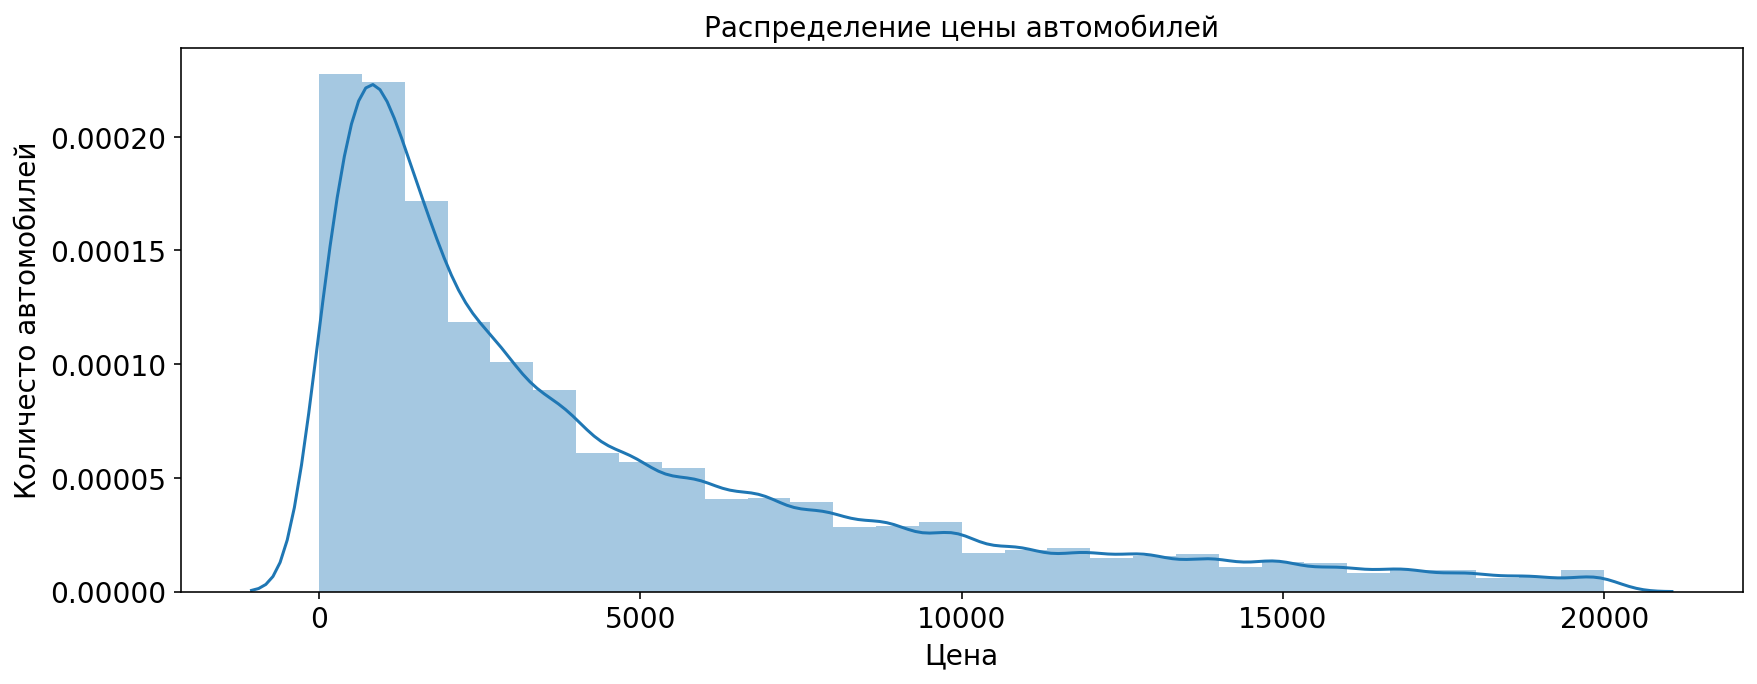

In [16]:
drawDistributionPlot(raw_autos, 'Price', "Распределение цены автомобилей", "Цена", "Количесто автомобилей")

Наблюдаем, что с повышением цены, количество моделей уменьшается. Большинство значений в диапазоне от 0 до ~2500 евро. Узнаем характерный разброс.

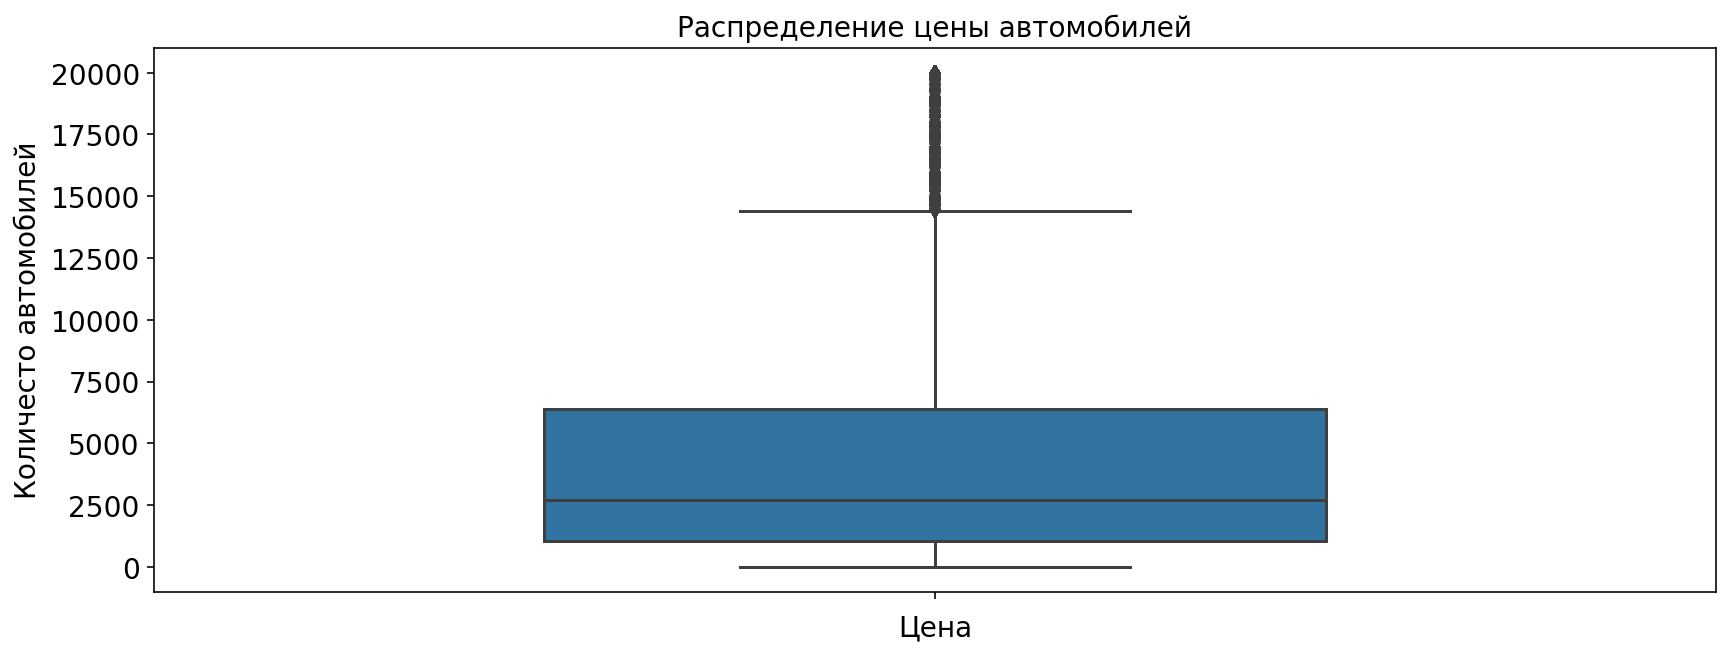

In [17]:
drawBoxPlot(raw_autos, 'Price', "Распределение цены автомобилей", "Цена", "Количесто автомобилей",True)

Посмотрим какое количество автомобилей имеет цену больше 15 тыс. евро.

In [18]:
raw_autos_price_greater_15 = raw_autos.query('Price > 15000')
raw_autos_price_greater_15.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0,39179,2016-04-07 04:45:21
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0,38350,2016-03-12 20:18:29
179,2016-03-08 20:58:31,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no,2016-03-08 00:00:00,0,95502,2016-04-06 01:17:03


Посмотрим какое количество значений.

In [19]:
print(f'Количество автомобилей с ценой больше 15 тыс. евро: {len(raw_autos_price_greater_15)}')
print(f'Доля автомобилей с ценой больше 15 тыс. евро от общего количества: {round(len(raw_autos_price_greater_15) / len(raw_autos) * 100, 2)}%')

Количество автомобилей с ценой больше 15 тыс. евро: 14881
Доля автомобилей с ценой больше 15 тыс. евро от общего количества: 4.2%


В размах *усов* попадают нормальные значения, за пределами находятся выборсы. После 15 тыс. евро, идут выбросы. 4.2% выбросов, не так много. Мы их оставим чтобы модель Машинного Обучения определяла эти случаи.

Посмотрим какие автомобили имеют цену 0 рублей.

In [20]:
raw_autos_price_zero = raw_autos.query('Price == 0')
raw_autos_price_zero.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10


 Посмотрим какое количество значений.

In [21]:
print(f'Количество автомобилей с ценой 0 евро: {len(raw_autos_price_zero)}')
print(f'Доля автомобилей с ценой 0 евро от общего количества: {round(len(raw_autos_price_zero) / len(raw_autos) * 100, 2)}%')

Количество автомобилей с ценой 0 евро: 10772
Доля автомобилей с ценой 0 евро от общего количества: 3.04%


3.04% доля автомобилей с ценой 0 евро. Предполагаю, что либо это ошибка в системе, которую надо сообщить разработчикам или менеджеру. Думаю, мы уберём обьекты с ценой 0 евро на этапе предобработки данных.

### Пробег

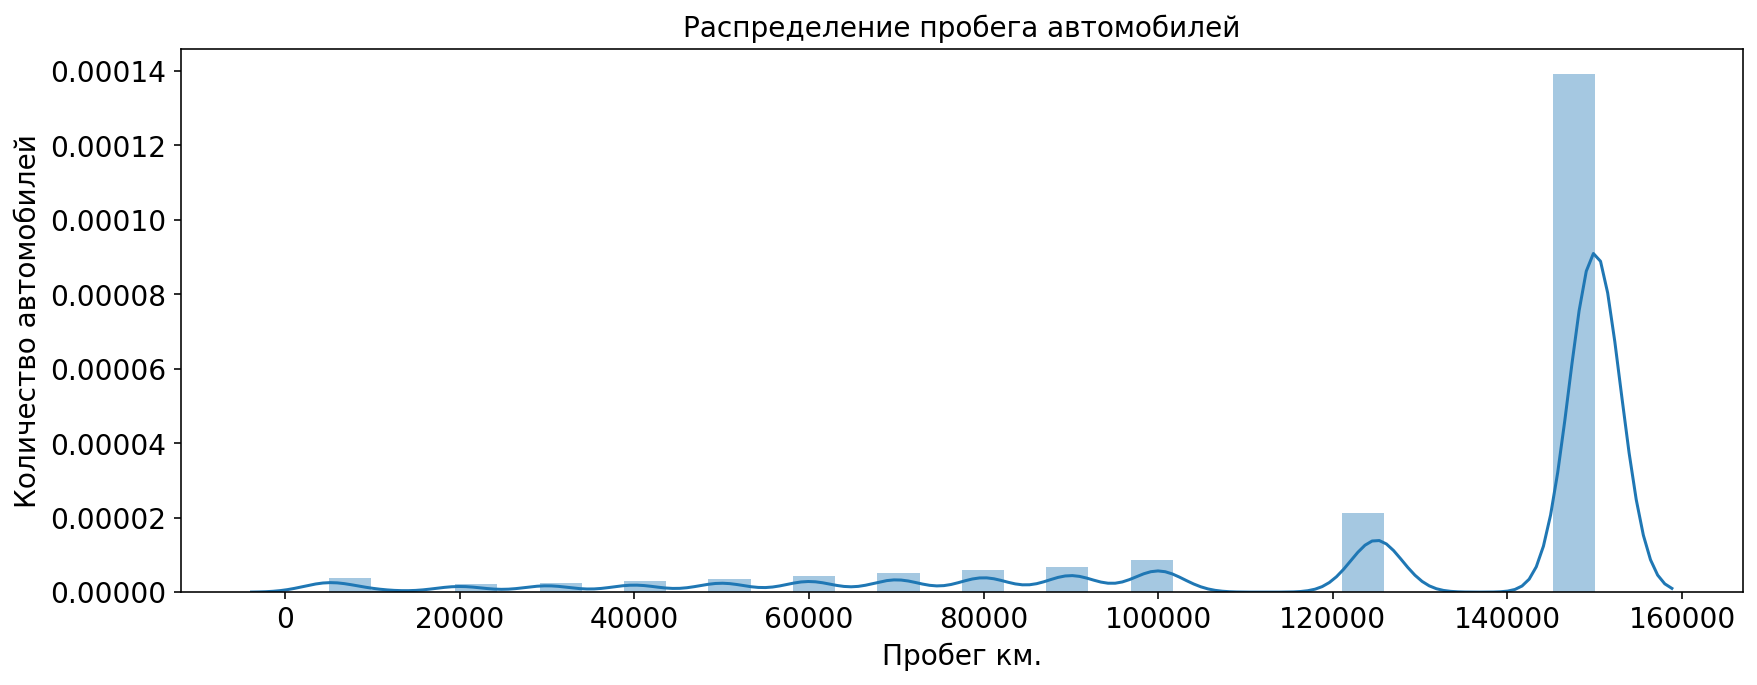

In [22]:
drawDistributionPlot(raw_autos, "Kilometer", "Распределение пробега автомобилей", "Пробег км.", "Количество автомобилей")

Заметим что, большинство автомоблией имеют пробег 140-150 тыс. км. Ошибка ли это в системе? Возможно, максимальное значение которое можно постать было 150 тыс. км не больше. Необходимо сообщить руководству об ошибке.

### Мощность

Посмотрим на автомобили с мощностью 0 л.с

In [23]:
raw_autos_power_zero = raw_autos.query('Power == 0')

In [24]:
raw_autos_power_zero.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34


Посмотрим какое количество значений.

In [25]:
print(f'Количество автомобилей с мощностью 0 л.с: {len(raw_autos_power_zero)}')
print(f'Доля автомобилей с мощностью 0 л.с от общего количества: {round(len(raw_autos_power_zero) / len(raw_autos) * 100, 2)}%')

Количество автомобилей с мощностью 0 л.с: 40225
Доля автомобилей с мощностью 0 л.с от общего количества: 11.35%


Доля составляет 11.35%. Скорее всего тут ошибка системы. Необходимо сообщить об этой ошибке руководству. Необходимо предобработать такие данные. Посмотрим на автомобиль с максимальным значением в мощности.

In [26]:
raw_autos_power_2000 = raw_autos.query('Power == 20000')

In [27]:
raw_autos_power_2000

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
219584,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09 00:00:00,0,19406,2016-03-30 08:47:08


Скорее всего пользователь тут опечатлся в поле мощности автомобиля при регистрации.

### Регистрация автомобиля

In [28]:
raw_autos.query('RegistrationYear == 1000').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
53577,2016-03-20 11:44:28,330,NaN,1000,NaN,0,polo,5000,0,NaN,volkswagen,NaN,2016-03-20 00:00:00,0,45259,2016-04-04 08:17:15
55605,2016-03-10 19:50:17,500,NaN,1000,NaN,0,NaN,5000,0,NaN,citroen,yes,2016-03-10 00:00:00,0,24811,2016-04-06 03:45:53
60017,2016-03-10 12:38:01,80,NaN,1000,NaN,0,NaN,5000,0,NaN,volkswagen,NaN,2016-03-10 00:00:00,0,93107,2016-04-07 04:45:57
66198,2016-03-08 14:50:20,1300,NaN,1000,auto,0,NaN,5000,6,petrol,sonstige_autos,NaN,2016-03-08 00:00:00,0,13156,2016-03-17 08:17:42


Ну тут уже точно плохие данные. Уберём их на этапе предобработки.

In [29]:
raw_autos.query('RegistrationYear == 9999').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15147,2016-03-14 00:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-13 00:00:00,0,32689,2016-03-21 23:46:46
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0,21769,2016-04-05 20:16:15
28390,2016-04-05 08:57:08,799,NaN,9999,NaN,0,3er,10000,4,petrol,bmw,NaN,2016-04-05 00:00:00,0,72116,2016-04-07 12:17:50
28965,2016-04-04 22:54:47,18000,NaN,9999,NaN,0,a_klasse,10000,0,petrol,mercedes_benz,NaN,2016-04-04 00:00:00,0,51379,2016-04-07 02:44:52
29426,2016-03-23 21:52:25,7999,NaN,9999,NaN,0,kaefer,10000,0,NaN,volkswagen,NaN,2016-03-23 00:00:00,0,47638,2016-04-06 03:46:40


Тоже самое и с максимальным значением.

## Вывод

354369 обьекта в датафрейме. 16 столбцов. Большинство столбцов имеют тип *object*. Количество обьектов в каждом столбце различается. У нас есть пропущенные значения. Следовательно, необходимо предобработать данные. Также стоит заметить, что некоторые столбцы будут не нужны в постройке моделей, такие как: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. Есть аномальные значения в столбцах: *RegistrationYear, Power, Kilometer*. Также есть нулевые значения: *NumberOfPictures, Price* и пропущенные значения в столбцах *VehicleType, Model, FuelType, NotRepaired*. Данные сырые, надо их тщательно предобработать. Также, у нас есть столбцы с датой, нам нужно перевести их в правильный тип данных *datetime*. Нам необходимо:
1. Предобработать данные
2. Обучить разные модели
3. Проанализировать скорость работы и точность моделей



---

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этом этапе нам необходимо предобработать данные. Данные сырые. Обработаем пропущенные значения. Проверим данные на дупликаты. Уберём ненужные признаки. Также, обработаем аномальные значения.

<a id="columnsProcessing"></a>
### Обработка столбцов

Переведём все наименования столбцов в нижний регистр. Напишем функцию.

In [30]:
def snake_case(s):
    """
    Преобразование строк из camelCase в snake_case.
    s - строка имя столбца
    """
    return ''.join('_' + c.lower()
                   if all([i != 0,
                           c.isupper(),
                           s[i - 1].islower()])
                   else c.lower()
                   for i, c in enumerate(s))

In [31]:
# Преобразуем колонки в snake_case
raw_autos.columns = map(snake_case, raw_autos.columns)
raw_autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

<a id="removeColumns"></a>
## Удаление лишних столбцов

Уберём лишние столбцы: *DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen*. 

In [32]:
raw_autos = raw_autos.drop(['date_crawled','date_created' ,'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
raw_autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<a id="missingValues"></a>
## Обработка пропущенных значений

Посмотрим сколько пропущенных значений в данных. Воспользуемся набором методов isna() и sum().

In [33]:
raw_autos.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
dtype: int64

У нас есть пропущенные значения в следующих столбцах: *vehicle_type, gearbox, model, fuel_type, not_repaired*.

Создадим копию датафрейма

In [34]:
raw_autos_copy = raw_autos.copy()

Давайте удалим пропущенные значения.

In [35]:
raw_autos_copy = raw_autos_copy.dropna(subset=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired'])
raw_autos_copy.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

In [36]:
print(f'Количество обьектов до удаления пропущенных значений: {len(raw_autos)}')
print(f'Количество обьектов после удаления пропущенных значений: {len(raw_autos_copy)}')
deleted_obj = len(raw_autos) - len(raw_autos_copy)
print(f'Количество обьектов удалено: {deleted_obj}')
print(f'Доля удаленных обьектов: {round(deleted_obj / len(raw_autos) * 100, 2)}%')

Количество обьектов до удаления пропущенных значений: 354369
Количество обьектов после удаления пропущенных значений: 245814
Количество обьектов удалено: 108555
Доля удаленных обьектов: 30.63%


Около 30% обьектов было удалено. Давайте попробуем восстановить данные.

Напишем функцию, которая будет выводить количество строк с пропущенными значениями.

In [37]:
def checkMissingValues(columnName,df):
    print(columnName,"проверка на пропущенные значения, кол-во строк с пропущенным значением: ",len(df[df[columnName].isna()]))

### Vehicle Type

Чтобы избежать искажения данных, предлагаю заполнить пропущенные значения "unknown_type".

In [38]:
raw_autos['vehicle_type'] = raw_autos.vehicle_type.fillna("unknown_type")

In [39]:
checkMissingValues('vehicle_type', raw_autos)

vehicle_type проверка на пропущенные значения, кол-во строк с пропущенным значением:  0


### Gearbox

Посмотрим на уникальные значения в столбце *gearbox*.

In [40]:
raw_autos['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Выведем распределение

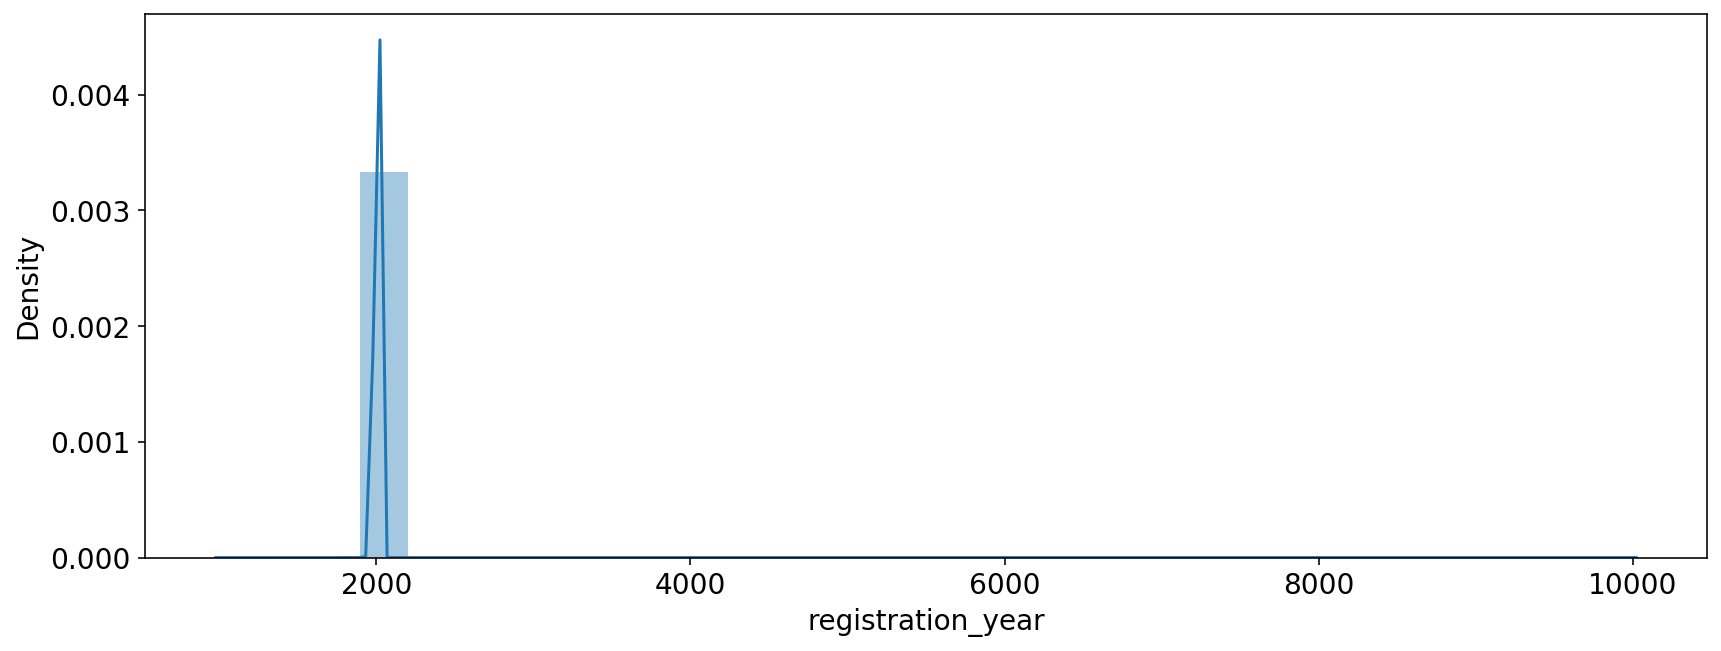

In [41]:
# KDE plot
plt.figure(figsize=(14,5))
plot  = sns.distplot(raw_autos['registration_year'],bins=30, kde=True)
plt.show()

Возьмём адекватный интервал

In [42]:
raw_autos_copy = raw_autos.query('registration_year > 1900 and registration_year < 2020')

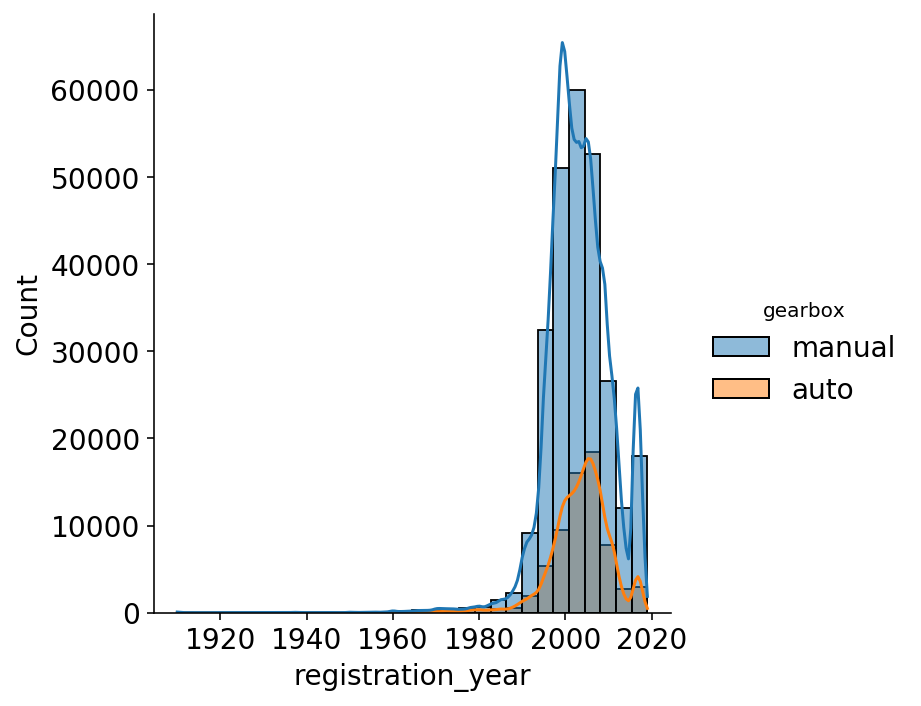

In [43]:
sns.displot(data = raw_autos_copy, x='registration_year',bins=30, kde=True, hue='gearbox')
plt.show()

Первая автоматическая коробка передач была установлена в [1947 году](https://akppoff.ru/korobka-avtomat/kto-pridumal). Можем смело предположить, что автомобили до 1947 года имели механическую коробку передач

In [44]:
raw_autos.loc[raw_autos['registration_year'] < 1947, 'gearbox'] = raw_autos.loc[raw_autos['registration_year'] < 1947, 'gearbox'].fillna("manual")

Чтобы избежать искаженние в данных, заполним остальные пропущенные значения - "unknown_gearbox". 

In [45]:
raw_autos['gearbox'] = raw_autos.gearbox.fillna("unknown_gearbox")

In [46]:
checkMissingValues('gearbox', raw_autos)

gearbox проверка на пропущенные значения, кол-во строк с пропущенным значением:  0


### Model

Чтобы избежать искажения в данных, заполним пропущенное значение - "unknown_model". 

In [47]:
raw_autos['model'] = raw_autos.model.fillna("unknown_model")

In [48]:
checkMissingValues('model', raw_autos)

model проверка на пропущенные значения, кол-во строк с пропущенным значением:  0


### Fuel type

Тоже самое сделаем со столбцом *fuel type*

In [49]:
raw_autos['fuel_type'] = raw_autos.fuel_type.fillna("unknown_fuel_type")

In [50]:
checkMissingValues('fuel_type', raw_autos)

fuel_type проверка на пропущенные значения, кол-во строк с пропущенным значением:  0


### Not repaired

Предлагаю заменить пропущенные значения столбца *not_repaired* на значение *unknown_repair_status*. 

In [51]:
raw_autos['not_repaired'] = raw_autos['not_repaired'].fillna('unknown_repair_status')

In [52]:
checkMissingValues('not_repaired', raw_autos)

not_repaired проверка на пропущенные значения, кол-во строк с пропущенным значением:  0


In [53]:
raw_autos.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

Перейдём к обработке дупликатов

<a id="duplicateValues"></a>
## Обработка дупликатов

Необходимо установить наличие дупликатов. Если появятся дупликаты - удаляем их, иначе наше исследование может привести к некорректным результатам. Воспользуемся набором методов *duplicated()* и *sum()*.

In [54]:
print(f'Количество дупликатов: {raw_autos.duplicated().sum()}')
print(f'Доля дупликатов в датасете: {round(raw_autos.duplicated().sum() / len(raw_autos),2)}%')

Количество дупликатов: 27543
Доля дупликатов в датасете: 0.08%


27543 Дупликатов. Придётся их удалить.

In [55]:
raw_autos = raw_autos.drop_duplicates().reset_index(drop=True)

<a id="abnormalValues"></a>
## Обработка аномальных значений

Займемся обработкой аномальных значений. Ранее на этапе обзора данных, мы выделили некоторые столбцы, которые имеют аномальные значения.

### Registration Year

Мы заметили максимальное значение - 9999 год и минимальное значение 1000 год.

In [56]:
reg_year_1000 = raw_autos.query('registration_year == 1000')
reg_year_1000.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
15962,190,unknown_type,1000,manual,0,mondeo,5000,0,unknown_fuel_type,ford,unknown_repair_status
52637,330,unknown_type,1000,manual,0,polo,5000,0,unknown_fuel_type,volkswagen,unknown_repair_status
54605,500,unknown_type,1000,manual,0,unknown_model,5000,0,unknown_fuel_type,citroen,yes
58886,80,unknown_type,1000,manual,0,unknown_model,5000,0,unknown_fuel_type,volkswagen,unknown_repair_status
64859,1300,unknown_type,1000,auto,0,unknown_model,5000,6,petrol,sonstige_autos,unknown_repair_status


In [57]:
reg_year_9999 = raw_autos.query('registration_year == 9999')
reg_year_9999.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
15063,0,unknown_type,9999,unknown_gearbox,0,unknown_model,10000,0,unknown_fuel_type,sonstige_autos,unknown_repair_status
17155,700,unknown_type,9999,unknown_gearbox,0,other,10000,0,unknown_fuel_type,opel,unknown_repair_status
28086,799,unknown_type,9999,unknown_gearbox,0,3er,10000,4,petrol,bmw,unknown_repair_status
28648,18000,unknown_type,9999,unknown_gearbox,0,a_klasse,10000,0,petrol,mercedes_benz,unknown_repair_status
29101,7999,unknown_type,9999,unknown_gearbox,0,kaefer,10000,0,unknown_fuel_type,volkswagen,unknown_repair_status


In [58]:
print(f'Количество автомобилей с регистрацией 1000 года: {len(reg_year_1000)}')
print(f'Количество автомобилей с регистрацией 9999 года: {len(reg_year_9999)}')

Количество автомобилей с регистрацией 1000 года: 35
Количество автомобилей с регистрацией 9999 года: 24


Следовательно, отфильтруем автомобили c регистрацией от 1901 до 2016 года.

In [59]:
raw_autos_upd = raw_autos.query('registration_year > 1900 and registration_year < 2017').reset_index(drop=True)

### Power

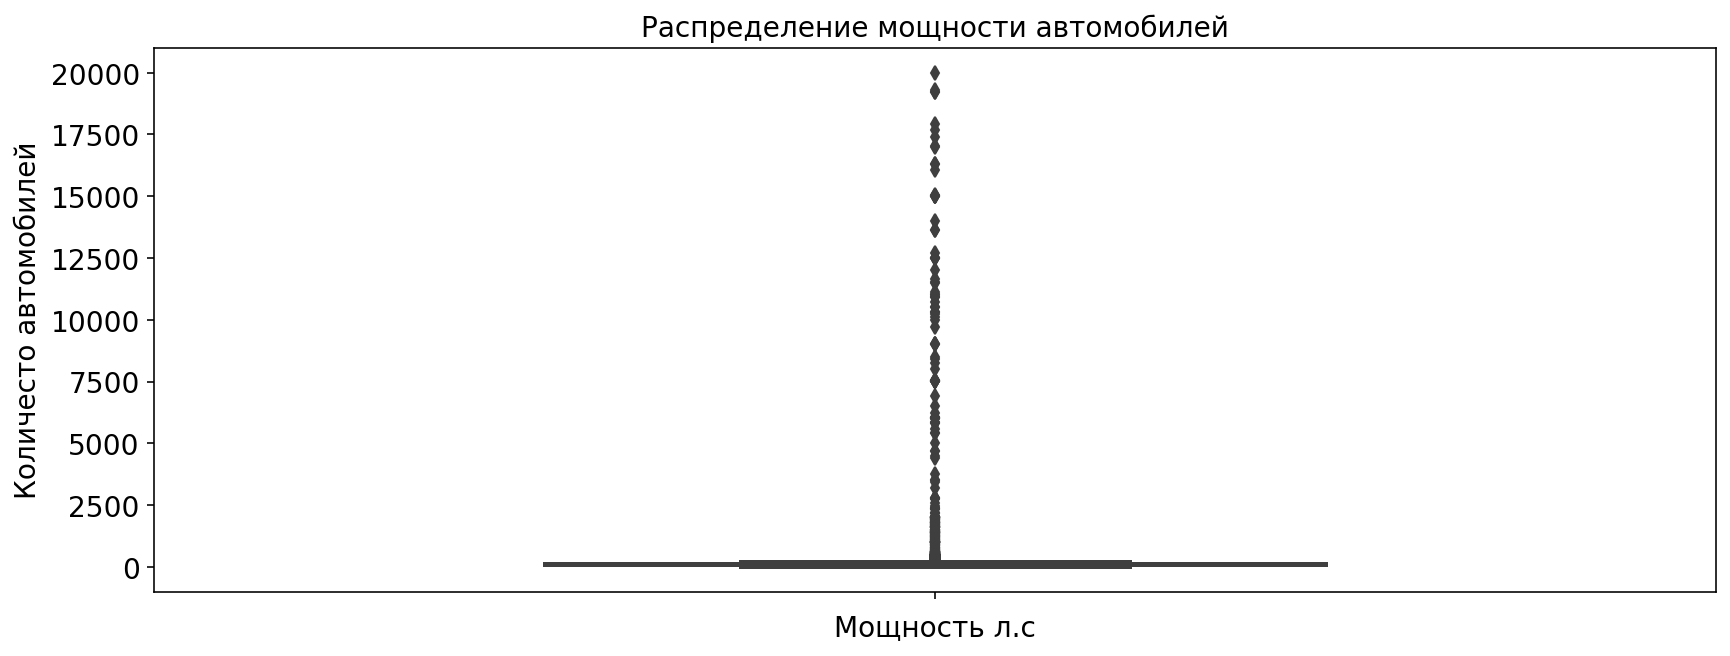

In [60]:
drawBoxPlot(raw_autos_upd, 'power', "Распределение мощности автомобилей", "Мощность л.с", "Количесто автомобилей",True)

Посмотрим на количество строк, где power < 10 и сколько машин, у которых power > 700.

In [61]:
num_of_cars_power_10 = len(raw_autos_upd.query('power < 10'))
num_of_cars_power_greater_500= len(raw_autos_upd.query('power > 700'))
print(f'Количество строк с power < 10: {num_of_cars_power_10}')
print(f'Количество строк с power > 700: {num_of_cars_power_greater_500}')

Количество строк с power < 10: 33620
Количество строк с power > 700: 316


Посмотрим на строки, где power > 700. Может это какие-нибудь [суперкары](https://auto.drom.ru/used/all/?minpower=650&order=price&order_d=desc)? 

In [62]:
raw_autos_upd.query('power > 700').sort_values(by='price', ascending=False).head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
78816,18550,sedan,2013,manual,1288,c_klasse,90000,11,gasoline,mercedes_benz,no
42513,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,unknown_repair_status
206195,15499,wagon,2012,manual,13636,c_klasse,125000,4,gasoline,mercedes_benz,no
44277,15000,coupe,2013,auto,751,unknown_model,10000,1,petrol,sonstige_autos,no
175323,13200,small,2013,manual,871,other,20000,1,petrol,opel,no
231901,13000,wagon,2010,manual,9013,a3,5000,12,gasoline,audi,unknown_repair_status
239306,12800,suv,2008,manual,1701,tiguan,150000,12,gasoline,volkswagen,no
290463,12000,wagon,2008,manual,1700,c_klasse,150000,8,gasoline,mercedes_benz,no
197053,11950,convertible,2008,manual,16312,a4,20000,4,petrol,audi,no
277257,11900,wagon,2007,auto,16311,5er,150000,10,gasoline,bmw,no


Суперкаров не оказалось, следовательно возьмем интервал 10 < power < 700

In [63]:
raw_autos_upd = raw_autos.query('power > 10 and power < 700')

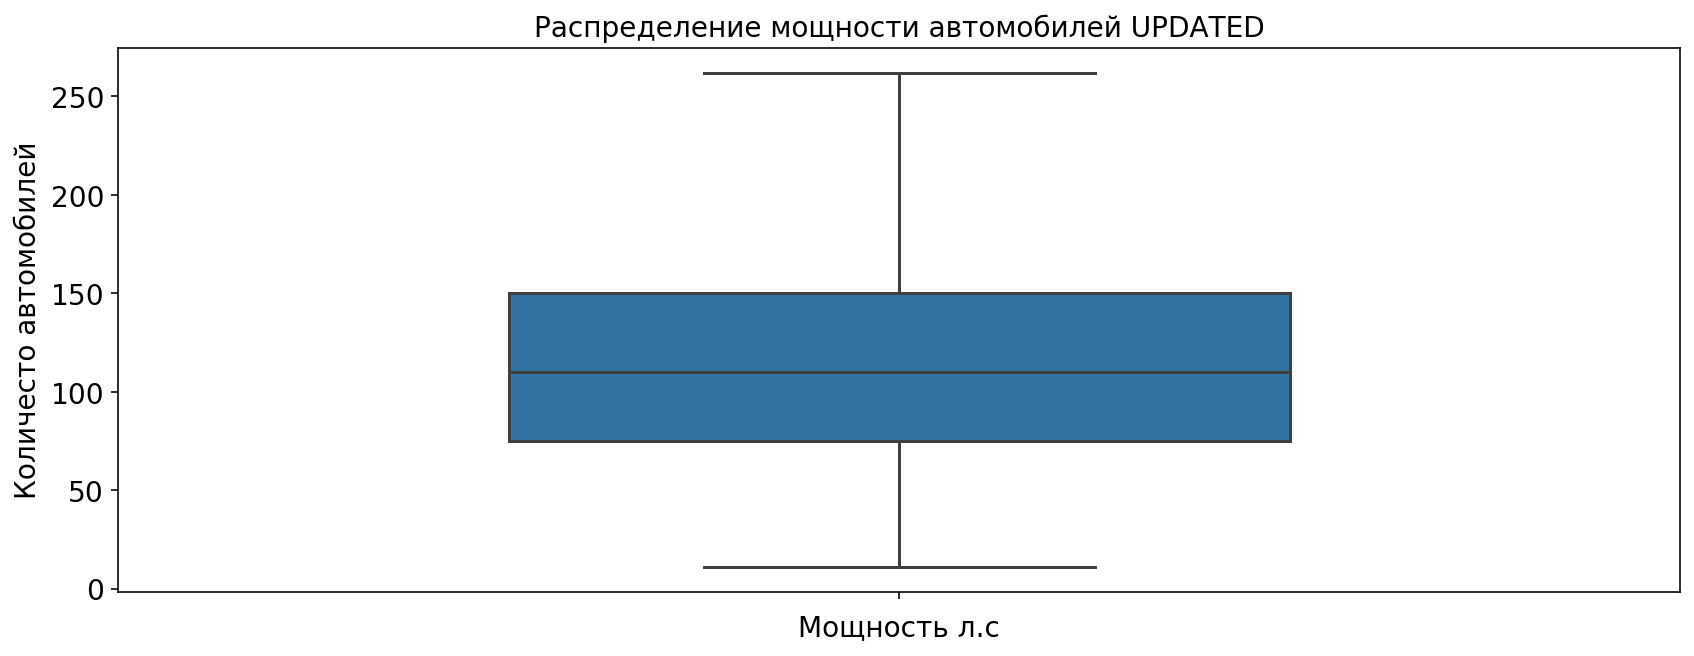

In [64]:
drawBoxPlot(raw_autos_upd, 'power', "Распределение мощности автомобилей UPDATED", "Мощность л.с", "Количесто автомобилей")

### Kilometer

In [65]:
raw_autos_upd.describe()['kilometer']

count   289215.000
mean    128507.097
std      36823.463
min       5000.000
25%     125000.000
50%     150000.000
75%     150000.000
max     150000.000
Name: kilometer, dtype: float64

В среднем пробег составляет 128 тыс. км. Обратим внимание на значение 50% и 75% персентиль и на максимальное значение - 150 тыс. км. Ошибка ли это в записи данных? Может в форме, где заполняли информацию, было зафиксировано максимальное значиние равно 150 тыс. км?

### Registration Month

In [66]:
raw_autos_upd.describe()['registration_month']

count   289215.000
mean         5.913
std          3.620
min          0.000
25%          3.000
50%          6.000
75%          9.000
max         12.000
Name: registration_month, dtype: float64

Обратим внимание на минимальное и максимальное значения, 0 и 12 соответственно. Несоответствие количества месяцев.

Думаю нам не понадобится этот столбец в постройке модели машинного обучения. Так что не будем предобрабатывать этот столбец.

### Price

In [67]:
raw_autos_upd.describe()['price']

count   289215.000
mean      4688.245
std       4594.241
min          0.000
25%       1200.000
50%       2999.000
75%       6800.000
max      20000.000
Name: price, dtype: float64

Есть нулевые значения. Посмотрим на значения

In [68]:
raw_autos_upd.query('price < 2').head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
59,1,suv,1994,manual,286,unknown_model,150000,11,unknown_fuel_type,sonstige_autos,unknown_repair_status
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
231,0,wagon,2001,manual,115,mondeo,150000,0,unknown_fuel_type,ford,unknown_repair_status


In [69]:
print(f'Количество автомобилей с ценой 0: {len(raw_autos_upd.query("price == 0"))}')

Количество автомобилей с ценой 0: 6200


Отфильтруем машины, цена которых равно 0 евро.

In [70]:
raw_autos_upd = raw_autos_upd.query('price > 0').reset_index(drop=True)

In [71]:
raw_autos_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283015 entries, 0 to 283014
Data columns (total 11 columns):
price                 283015 non-null int64
vehicle_type          283015 non-null object
registration_year     283015 non-null int64
gearbox               283015 non-null object
power                 283015 non-null int64
model                 283015 non-null object
kilometer             283015 non-null int64
registration_month    283015 non-null int64
fuel_type             283015 non-null object
brand                 283015 non-null object
not_repaired          283015 non-null object
dtypes: int64(5), object(6)
memory usage: 23.8+ MB


Напишем функцию которая проверит:
1. Пропущенные значения
2. Дупликаты
3. Есть ли отрицательные значения
4. Соответствующие типы данных float64

In [72]:
def get_preprocessed_data(raw_data):
    """
    Функция проверяет данные. Возвращает предобработанные данные для обучения.
    raw_data - данные для проверки
    """
    # проверяем данные
    assert raw_data.isna().sum().sum() == 0, 'В данных не должно быть пропущенных значений!'
    assert raw_data.select_dtypes(exclude=[np.float64, np.int64, np.object, np.datetime64]).size == 0, 'Данные должны иметь только численный тип данных!'
    assert raw_data.duplicated().sum().sum() == 0, 'В данных не должно быть дупликатов!'
    print('Данные проверку прошли!')
    #создаем копию оригинального датафрейма
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [73]:
autos = get_preprocessed_data(raw_autos_upd)

Данные проверку прошли!


<a id="encoding"></a>
## Кодирование

Столбцы *vehicle_type*, *model*, *fuel_type*, *brand*, *not_repaired*. - категориальные признаки. Необходимо их перевести в численные признаки. Используем технику кодирования [Ordinal Encoding](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/), так как у нас много значений в категориальных признаков.

In [74]:
# создаем обьект
encoder = OrdinalEncoder()

Используем функцию [fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder.fit_transform), которая возьмет лист категориальных признаков и преобразует их. Создадим новый датафрейм с уже преобразоваными признаками. 

In [75]:
autos_ordinal = autos.copy()
autos_ordinal.loc[:,['vehicle_type', 'model', 'fuel_type', 'brand', 'not_repaired','gearbox']] = encoder.fit_transform(autos_ordinal.loc[:,['vehicle_type', 'model', 'fuel_type', 'brand', 'not_repaired','gearbox']])
autos_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,18300,2.000,2011,1.000,190,227.000,125000,5,2.000,1.000,2.000
1,9800,6.000,2004,0.000,163,117.000,125000,8,2.000,14.000,1.000
2,1500,5.000,2001,1.000,75,116.000,150000,6,6.000,38.000,0.000
3,3600,5.000,2008,1.000,69,101.000,90000,7,2.000,31.000,0.000
4,650,4.000,1995,1.000,102,11.000,150000,10,6.000,2.000,2.000


<a id="dataSeparation"></a>
## Разделение данных

Нам необходимо проверить модель на правильные предсказания. Мы разделим выборку для кросс-валидации. Разделим исходные данные на 2 выборки: обучающую и тестовую в соотношениее (*75/25*). Валидационная выборка формируется во время кросс-валидации.

Для начала напишем функцию разделения целевого признака от остальных.

In [76]:
def target_features_split(data,column):
    """
    Функция разделяет данные на целевой признак и признаки. Функция возвращает 1) целевой признак, 2) признаки без целевого
    data - данные которые необходимо разделить.
    column - целевой признак
    """
    return data[column], data.drop(column,axis=1)

Зафиксируем ***random_state***.

In [77]:
random_state_value = 42

In [78]:
target, features = target_features_split(autos_ordinal, 'price')

В sklearn есть функция для деления выборки *train_test_split()* воспользуемся ей. Напишем функцию для деления данных и печати размеров полученных наборов, чтобы избежать ошибок.

In [79]:
def sampleSize(original, train, test):
    """
    Функция для печати полученных наборов.
    original - исходные данные
    train - обучающая выборка
    valid - валидационная выборка
    test - тестовая выборка
    """
    print(f'Размер исходных данных {len(original)}')
    print(f'Размер тренировочной выборки {len(train)}')
    print(f'Размер тестовой выборки {len(test)}')

In [80]:
def cross_val_splitting_data(target,features):
    """
    Функция для разделения данных на обучающую и тестовую выборки. Функция возвращает признаки и целевой признак: обучающей и тестовой выборки
    target - целевой признак
    features - признаки без целевого
    """
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=random_state_value,test_size=0.25)
    # проверяем размеры выборок
    sampleSize(features,features_train,features_test)
    return features_train,target_train, features_test, target_test

In [81]:
features_train_cross, target_train_cross, features_test_cross, target_test_cross = cross_val_splitting_data(target, features)

Размер исходных данных 283015
Размер тренировочной выборки 212261
Размер тестовой выборки 70754


<a id="standardization"></a>
## Стандартизация

У наших признаков разный масштаб. Необходимо привести признаки к одному масштабу.

Воспользуемся отдельной структурой библиотеки *sklearn* для стандартизирования - *Standard Scaler*.

In [82]:
def crossValStandardScaling(features_train, features_test):
    """
    Функция для стандартизации данных. Возвращает стандартизированые данные из обучающей и тестовой выборки
    features_train - признаки обучающей выборки
    features_test - признаки тестовой выборки
    """
    features_train_copy = features_train.copy()
    features_test_copy = features_test.copy()
    # Инициализируем scaler
    scaler = StandardScaler()
    # численные столбцы 
    numeric = ['power','registration_year', 'kilometer']
    # настраиваем scaler на обучающей выборке
    scaler.fit(features_train_copy.loc[:,numeric])
    # преобразуем выборки с помощью transform() функции.
    features_train_copy.loc[:,numeric] = scaler.transform(features_train_copy.loc[:,numeric])
    features_test_copy.loc[:,numeric] = scaler.transform(features_test_copy.loc[:,numeric])
    
    return features_train_copy, features_test_copy

In [83]:
features_train_cross, features_test_cross = crossValStandardScaling(features_train_cross, features_test_cross)

## Вывод

На этапе предобработки данных, мы:
1. Обработали столбцы. Привели все столбцы к нижнему регистру.
2. Обработали пропущенные значения.
3. Сделали кодирование. 
4. Убрали ненужные столбцы.
4. Сделали финальные проверки с помощью кастомной функции. Данные проверку прошли.
5. Мы разделили выборку для кросс-валидации. Разделили исходные данные на 2 выборки: обучающую и тестовую в соотношениее (*75/25*).
6. Привели признаки к одному масштабу с помощью стандартизации.

Данные предобработаны и готовы к обучению моделей машинного обучения. 

<a id="MLmodelResearch"></a>
# Этап 3 - Исследование моделей машинного обучения

На этом этапе нам необходимо исследовать модели машинного обучения. Найти лучшую модель.

Необходимо проверить некоторые модели регрессии. Переберём гиперпараметры, посмотрим значения метрик:
- RMSE (квадратный корень из средней квадратичной ошибки).

Мы будем вести учёт моделей машинного обучения. Создадим лист моделей с помощью словаря. Потом из словаря преобразуем таблицу моделей со всеми метриками.

In [84]:
ml_models_stats = dict()

Напишем функцию для оценки моделей. 

In [85]:
def evaluate_model(model_name, model,training_time,features_test, target_test,features_train, target_train,parameters=None):
    """
    Функция оценивает модель по метрике rmse, добавляет модель в таблицу с метрикой и временем обучения.
    model_name - имя модели
    model - сама модель
    train_score - точность на обучающей выборке
    features_test - признаки на тестовой выборке
    target_test - целевой признак на тестовой выборке
    parameters - параметры модели
    """
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    print()
    predict_start = datetime.datetime.now()
    predicted_test = model.predict(features_test)
    predict_time = datetime.datetime.now() - predict_start
    # MSE - средняя квадратичная ошибка
    mse_test = mean_squared_error(target_test, predicted_test)
    # RMSE - квардратный корень из средней квадратичной ошибки
    rmse_test = mse_test ** 0.5
    predicted_train = model.predict(features_train)
    # MSE - средняя квадратичная ошибка
    mse_train = mean_squared_error(target_train, predicted_train)
    # RMSE - квардратный корень из средней квадратичной ошибки
    rmse_train = mse_train ** 0.5
    
    print(f'RMSE модели на обучающей выборке: {rmse_train}')
    print(f'RMSE модели на тестовой выборке: {rmse_test}')
    print(f'Время обучения модели: {training_time}')
    print(f'Время предсказания модели: {predict_time}')
    # добаляем модель
    ml_models_stats[model_name] = {
        'название': model_name,
        'время_обучения': training_time,
        'время_предсказания':predict_time,
        'rmse_test':rmse_test,
        'rmse_train':rmse_train
    }
    print()
    print('Модель успешно добавлена в таблицу!')

Подоберём параметры с помощью GridSearchCV, в которой встроена кросс-валидация.

Создадим scorer для GridSearch

In [86]:
def rmse(target,predictions):
    """
    Функция для вычисления RMSE
    target - целевой признак
    predictions - предсказания
    """
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

In [87]:
# создадим scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Линейнейная регрессия не будет работать корректно с ordinal encoding. Следовательно, ее пропустим и начнём с дерева решений. Мы бы сделали OHE encoding, однако, у нас очень много значений в категориальных признаках. OHE encoding наплодить кучу столбцов, что затруднит предсказание модели. 

### Дерево Решений

In [88]:
start = datetime.datetime.now()
# создаем модель
decision_tree_model = DecisionTreeRegressor()
# параметры
decision_parameters = {
              "max_depth": range(1, 11),
              "min_samples_leaf": range(1, 11)
}

decision_grid =  RandomizedSearchCV(estimator=decision_tree_model, param_distributions=decision_parameters, cv=5,scoring=rmse_scorer, n_iter = 20, n_jobs=-1)
decision_grid.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [89]:
evaluate_model('Дерево решений', decision_grid,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,decision_grid.best_params_)

Оценка модели: Дерево решений
с параметрами: {'min_samples_leaf': 10, 'max_depth': 10}

RMSE модели на обучающей выборке: 1910.28843324776
RMSE модели на тестовой выборке: 1992.7431056252549
Время обучения модели: 0:00:30.442216
Время предсказания модели: 0:00:00.032113

Модель успешно добавлена в таблицу!


У Дерева Решений получше результат. Модель также быстро обучилась. Ошибается на ~2000 евро

### Рандомный лес

In [90]:
start = datetime.datetime.now()
# создаем модель
random_forest_model = RandomForestRegressor()
# Параметры, которые мы перебираем
gs_params = {
    'max_depth': range(1, 21),
    'n_estimators':range(1,61,10)
}
# Создаем GridSearch для модели
forest_rs = RandomizedSearchCV(estimator=random_forest_model,param_distributions=gs_params,scoring=rmse_scorer,cv=5,n_iter = 20,n_jobs=-1)
# Обучаем модель
forest_rs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [91]:
evaluate_model('Рандомный лес', forest_rs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,forest_rs.best_params_)

Оценка модели: Рандомный лес
с параметрами: {'n_estimators': 41, 'max_depth': 19}

RMSE модели на обучающей выборке: 942.0961280178917
RMSE модели на тестовой выборке: 1666.2973356709363
Время обучения модели: 0:11:23.820245
Время предсказания модели: 0:00:01.094765

Модель успешно добавлена в таблицу!


Рандомный лес обучается долго чем остальные модели. Однако, он показал хороший результат на обучающей выборке и на тестовой. На обучающей ошибается ~ 942 евро. На тестовой выборке ошибается на 1666 евро.

### XGBoost

In [92]:
start = datetime.datetime.now()
xgb_params = {
    "max_depth": range(3, 10,2),
    "min_child_weight": range(1,6,2)
}
xgb = xgb.XGBRegressor(nthread=-1) 
xgb_gs = GridSearchCV(xgb, xgb_params, scoring=rmse_scorer,n_jobs=-1)
xgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [93]:
evaluate_model('XGBoost', xgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,xgb_gs.best_params_)

Оценка модели: XGBoost
с параметрами: {'max_depth': 9, 'min_child_weight': 3}

RMSE модели на обучающей выборке: 1256.132328678058
RMSE модели на тестовой выборке: 1615.2797843676822
Время обучения модели: 0:05:10.405977
Время предсказания модели: 0:00:00.439887

Модель успешно добавлена в таблицу!


XGBoost тоже показал хорошие результаты на обучающей и тестовой. Однако, обучение модели тоже заняло некоторое время. 

### LightGBM

In [94]:
start = datetime.datetime.now()
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [10,200,250]
}
lgb_reg = lgb.LGBMRegressor()
lgb_gs = GridSearchCV(lgb_reg, lgb_params,scoring=rmse_scorer,n_jobs=-1)
lgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [95]:
evaluate_model('LightGBM', lgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,lgb_gs.best_params_)

Оценка модели: LightGBM
с параметрами: {'boosting_type': 'gbdt', 'max_depth': 30, 'num_leaves': 250, 'objective': 'regression'}

RMSE модели на обучающей выборке: 1416.2791271046506
RMSE модели на тестовой выборке: 1606.765772967259
Время обучения модели: 0:03:59.303109
Время предсказания модели: 0:00:00.790812

Модель успешно добавлена в таблицу!


Лучший результат на тестовой выборке. Модель ошибаетсч на 1606 евро. Также, модель обучилась за ~4 минуты. 

### CatBoost

In [96]:
start = datetime.datetime.now()
catBoost_params = {
    'learning_rate': [1],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3]
}
catBoost_reg = CatBoostRegressor(loss_function='RMSE',random_state=random_state_value,silent=True,eval_metric="RMSE")
catBoost_gs = GridSearchCV(catBoost_reg, catBoost_params,scoring=rmse_scorer,n_jobs=-1)
catBoost_gs.fit(features_train_cross,  target_train_cross)
training_time = datetime.datetime.now() - start

In [97]:
evaluate_model('CatBoost', catBoost_gs,training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross,catBoost_gs.best_params_)

Оценка модели: CatBoost
с параметрами: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 1}

RMSE модели на обучающей выборке: 1380.7964664998067
RMSE модели на тестовой выборке: 1662.6493826463202
Время обучения модели: 0:10:48.601729
Время предсказания модели: 0:00:00.078539

Модель успешно добавлена в таблицу!


20 минут 0_0 Очень долго обучилась. Модель показала неплохой результат на тесте.

Проведем проверку на вменяемость. Обучим Dummy модель.

### Dummy

In [98]:
start = datetime.datetime.now()
# создаем модель
dummy_model = DummyRegressor(strategy="constant", constant=target_train_cross.median())
# тренируем модель
dummy_model.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start

In [99]:
evaluate_model('Дамми модель', dummy_model, training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross)

Оценка модели: Дамми модель

RMSE модели на обучающей выборке: 4925.31598536369
RMSE модели на тестовой выборке: 4935.895636107522
Время обучения модели: 0:00:00.010681
Время предсказания модели: 0:00:00.000474

Модель успешно добавлена в таблицу!


### Вывод

На этом этапе мы исследовали разные ML модели: Линейная Регрессия, Дерево Решение, Рандомный Лес, XGBoost, LightGBM, CatBoost. Написали функцию для оценки моделей. 

<br>

<a id="resultsRearchModel"></a>
# Этап 4 - Анализ скорость работы и качество моделей

На этом этапе надо проанализировать скорость работы и качество моделей.

Мы проверили 6 моделей машинного обучения (*Linear Regression*, *Decision Tree*, *Random Forest*, *XGBoost*, *LightGBM*, *CatBoost*). Подобрали параметры с помощью *GridSearchCV*, в котором встроена *кросс-валидация*

Для бизнеса важны следующие метрики: **точность, время обучения, время предсказания**. По этим метрикам будем выбирать лучшую модель.

Напишем дополнительную функцию для вывода графиков

In [100]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Создадим таблицу из полученных данных.

In [101]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

,название,время_обучения,время_предсказания,rmse_test,rmse_train
0,Дерево решений,00:00:30.442216,00:00:00.032113,1992.743,1910.288
1,Рандомный лес,00:11:23.820245,00:00:01.094765,1666.297,942.096
2,XGBoost,00:05:10.405977,00:00:00.439887,1615.280,1256.132
3,LightGBM,00:03:59.303109,00:00:00.790812,1606.766,1416.279
4,CatBoost,00:10:48.601729,00:00:00.078539,1662.649,1380.796
5,Дамми модель,00:00:00.010681,00:00:00.000474,4935.896,4925.316


Модели которые прошли проверку на вменяемость.

In [102]:
approved_models = ml_models.query("rmse_test < 4862.087")
approved_models

,название,время_обучения,время_предсказания,rmse_test,rmse_train
0,Дерево решений,00:00:30.442216,00:00:00.032113,1992.743,1910.288
1,Рандомный лес,00:11:23.820245,00:00:01.094765,1666.297,942.096
2,XGBoost,00:05:10.405977,00:00:00.439887,1615.280,1256.132
3,LightGBM,00:03:59.303109,00:00:00.790812,1606.766,1416.279
4,CatBoost,00:10:48.601729,00:00:00.078539,1662.649,1380.796


Все модели прошли проверку на вменяемость

Переведём время предсказания в милллисекунды

In [103]:
def milliseconds_from_timedelta(timedelta):
    """Перевод в миллисекунды с обьекта timedelta"""
    return timedelta.total_seconds() * 1e3

In [104]:
approved_models['время_предсказания_миллисекунды'] = approved_models['время_предсказания'].apply(milliseconds_from_timedelta)

Переведём время обучения в секунды

In [105]:
def seconds_from_timedelta(timedelta):
    """Перевод в секунды с обьекта timedelta"""
    return timedelta.total_seconds()

In [106]:
approved_models['время_обучения_секунды'] = approved_models['время_обучения'].apply(seconds_from_timedelta)

Найдём самую лучшую модель по метрике RMSE на тестовой выборке

,название,rmse_test
0,LightGBM,1606.766
1,XGBoost,1615.280
2,CatBoost,1662.649
3,Рандомный лес,1666.297
4,Дерево решений,1992.743


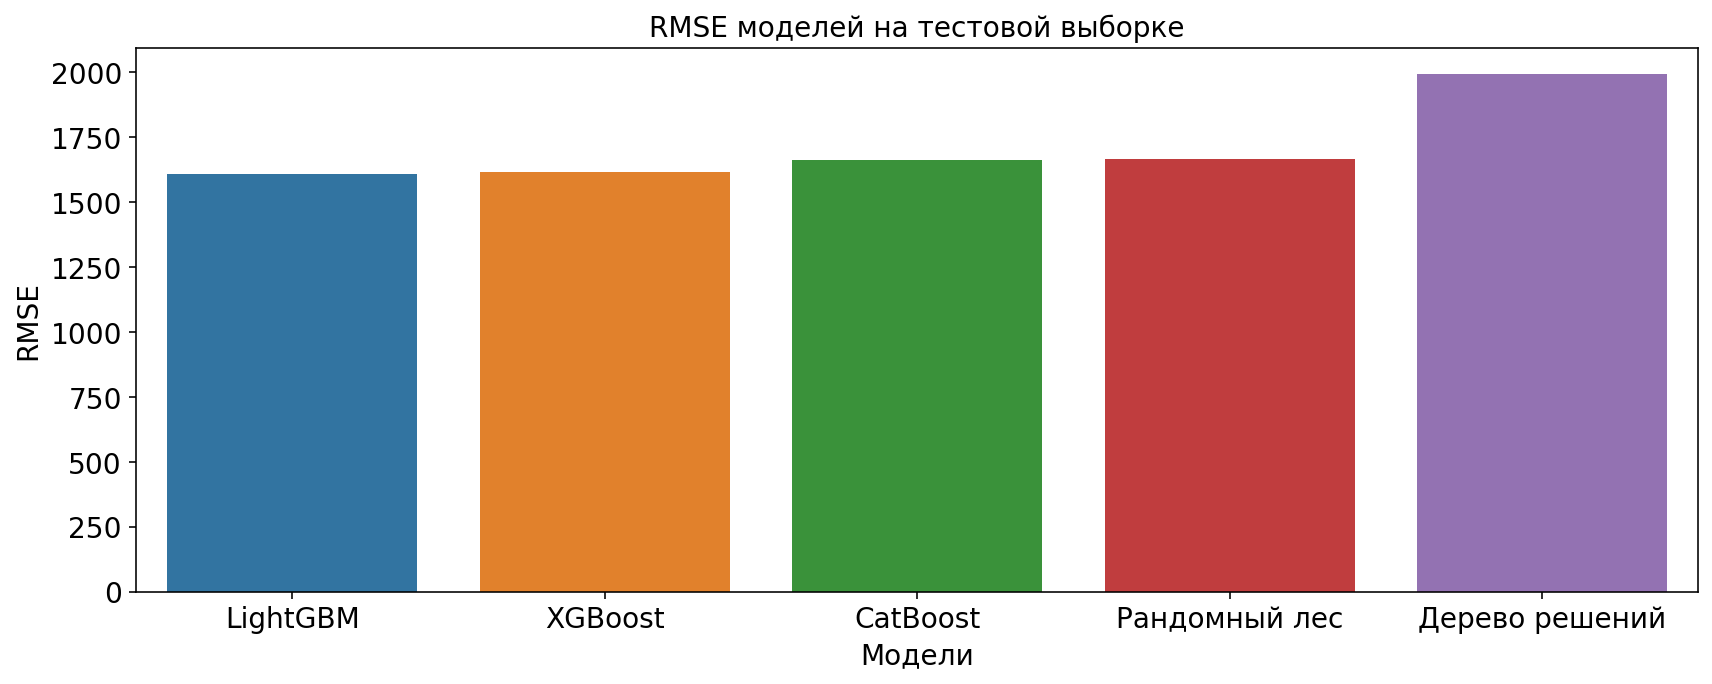

In [107]:
rmse_test_sorted = approved_models.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_test_sorted[['название','rmse_test']])
# Рисуем график
drawPlot(rmse_test_sorted, 'название','rmse_test','Модели','RMSE','RMSE моделей на тестовой выборке','название' )

На первом месте оказалась модель LightGBM с результатом - **1606.766**. Следом идет XGBoost с результатом - 1615.280

Найдём самую быструю модель в обучении

,название,время_обучения
0,Дерево решений,00:00:30.442216
1,LightGBM,00:03:59.303109
2,XGBoost,00:05:10.405977
3,CatBoost,00:10:48.601729
4,Рандомный лес,00:11:23.820245


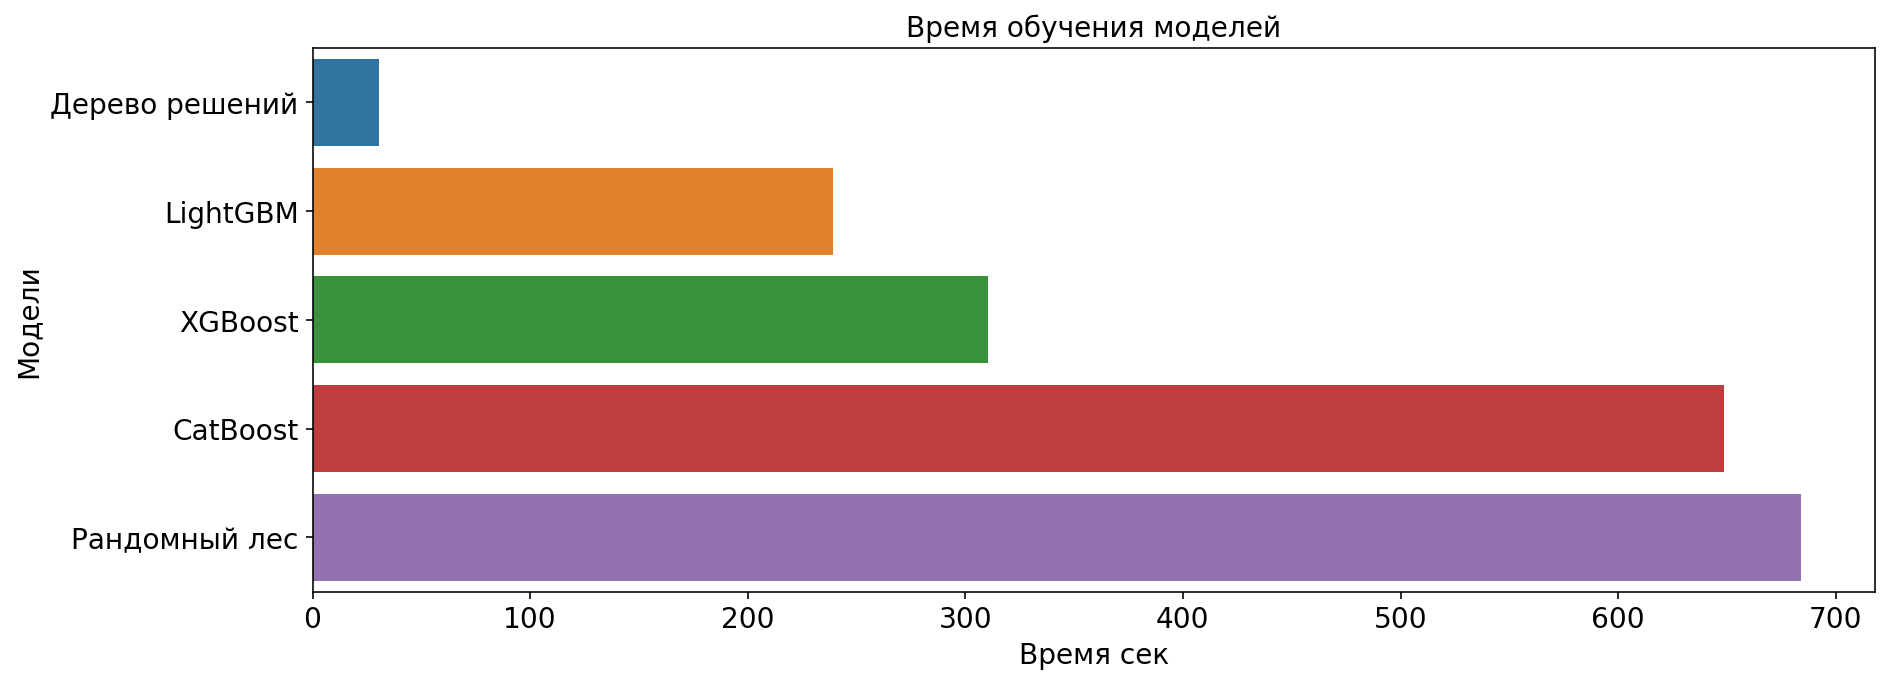

In [108]:
train_time_sorted = approved_models.sort_values(by='время_обучения_секунды',ascending=True).reset_index()
display(train_time_sorted[['название','время_обучения']])
# Рисуем график
drawPlot(train_time_sorted,'время_обучения_секунды','название','Время сек','Модели','Время обучения моделей','название' )

Меньше всего времени потратило Дерево Решений. Следом идут LightGBM и XGBoost. Рандомный лес - 11 минут

Найдём самую быструю модель в предсказании

,название,время_предсказания
0,Дерево решений,00:00:00.032113
1,CatBoost,00:00:00.078539
2,XGBoost,00:00:00.439887
3,LightGBM,00:00:00.790812
4,Рандомный лес,00:00:01.094765


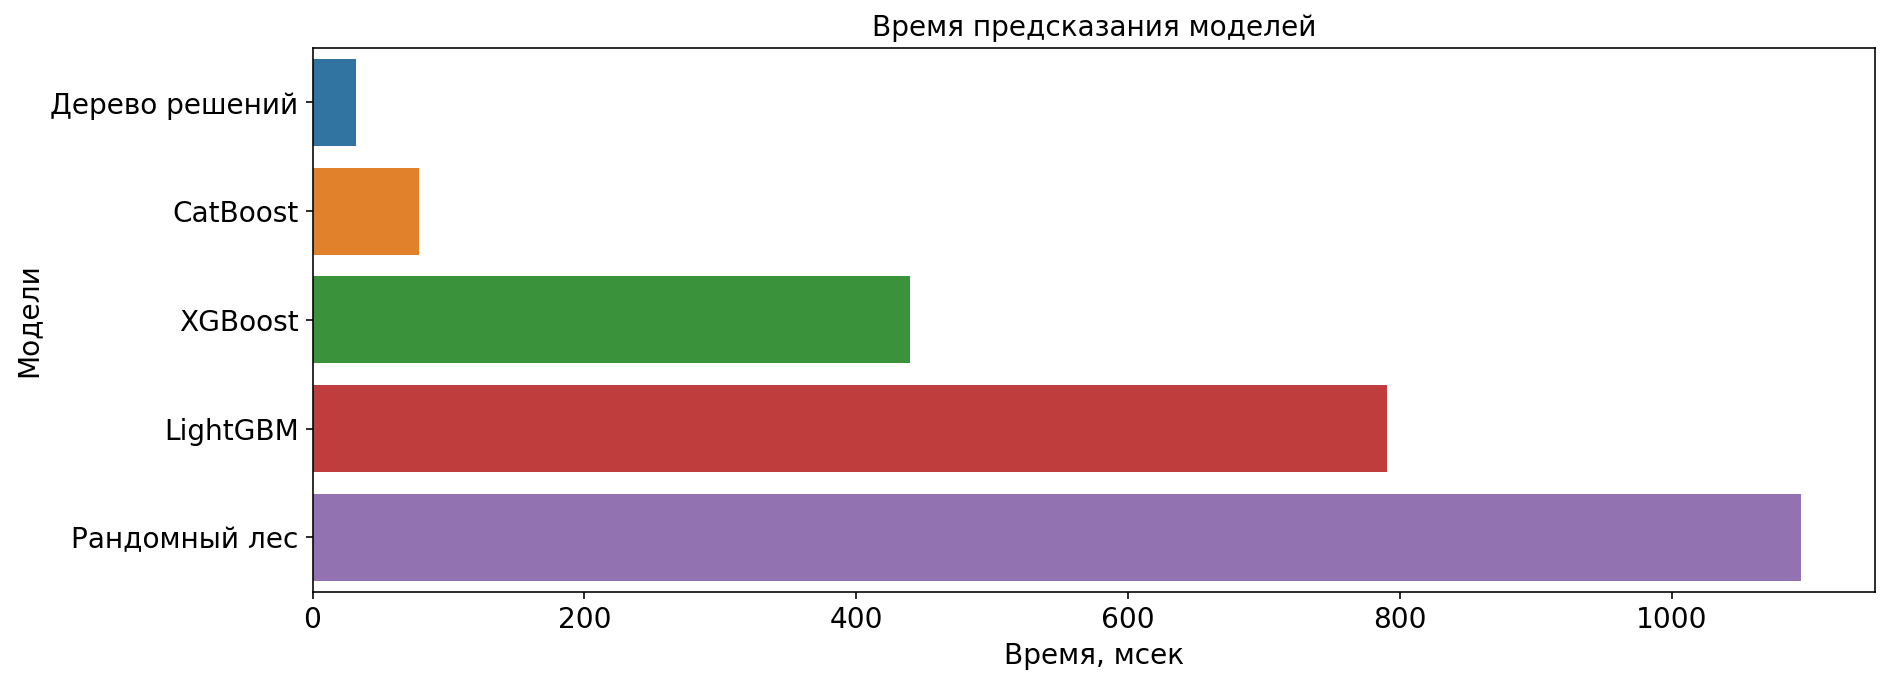

In [109]:
predict_time_sorted = approved_models.sort_values(by='время_предсказания_миллисекунды',ascending=True).reset_index()
display(predict_time_sorted[['название','время_предсказания']])
# Рисуем график
drawPlot(predict_time_sorted,'время_предсказания_миллисекунды','название','Время, мсек','Модели','Время предсказания моделей','название' )

Быстрое предсказание у Дерева Решений и CatBoost. Следом идет XGBoost. Самый последний - Рандомный Лес.

Основываясь на полученных результатах и графиках, выберем лучшую модель - **LightGBM**. У модели хороший показатель точности, среднее время обучения и предсказания.

<br>

<a id="results"></a>
# Этап 5 - Результаты работы

В ходе проекта мы успешно построили модели Машинного Обучения для быстрого определения стоимости автомобиля. Выбрали лучшую модель, которая соотвествует требованию бизнеса. В проекте мы сделали:
- Предобработку данных: 
    1. Обработали столбцы. Привели все столбцы к нижнему регистру.
    2. Обработали пропущенные значения.
    3. Сделали кодирование. 
    4. Убрали ненужные столбцы.
    4. Сделали финальные проверки с помощью кастомной функции. Данные проверку прошли.
    5. Мы разделили выборку для кросс-валидации. Разделили исходные данные на 2 выборки: обучающую и тестовую в соотношениее (*75/25*).
    6. Привели признаки к одному масштабу с помощью стандартизации.
    
- Исследовали модели Машинного обучения:
    1. Подобрали параметры для каждой модели с помощью GridSearchCV, в которой встроена кросс-валидация.
    2. Мы исследовали разные ML модели: Линейная Регрессия, Дерево Решение, Рандомный Лес, XGBoost, LightGBM, CatBoost.
    
- Провели анализ скорости и точности моделей: 
    1. Провели проверку на вменяемость. Все модели прошли тест.
    2. Основываясь на метриках, которые соотвествуют требованию бизнеса, выбрали лучшую модель - **LightGBM**.

### Информации по модели

In [110]:
approved_models.query('название == "LightGBM"')

,название,время_обучения,время_предсказания,rmse_test,rmse_train,время_предсказания_миллисекунды,время_обучения_секунды
3,LightGBM,00:03:59.303109,00:00:00.790812,1606.766,1416.279,790.812,239.303
